# **Step 1: Setting up Your Environment**

In this part of the hands-on, we set up an environment for data analysis and visualization in the Google Colab notebook. First, we allow the Google Colab notebook to access files stored in your Google Drive, enabling the use of data stored remotely. Then, we import libraries to set up a comprehensive R toolset for accessing data, conducting statistical analysis, and visualizing results effectively.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

MessageError: Error: credential propagation was unsuccessful

In [3]:
!pip install rpy2
%reload_ext rpy2.ipython

In [ ]:
%%R

install.packages("ggplot2")
library("ggplot2")

(as ‘lib’ is unspecified)








In [ ]:
%%R

install.packages("RColorBrewer")
library(RColorBrewer)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI0pBSN/downloaded_packages’



In [ ]:
%%R

install.packages("hexbin")
library(hexbin)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI0pBSN/downloaded_packages’



In [ ]:
%%R

install.packages("tidyverse")
library(tidyverse)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI0pBSN/downloaded_packages’



In [ ]:
%%R

install.packages("BiocManager")
library(BiocManager)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI0pBSN/downloaded_packages’




In [ ]:
%%R

BiocManager::install("DESeq2")
library(DESeq2)

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com


  'crayon', 'curl', 'data.table', 'DBI', 'dbplyr', 'devtools', 'digest',
  'evaluate', 'farver', 'fastmap', 'fs', 'gargle', 'ggplot2', 'gh', 'gtable',
  'highr', 'htmltools', 'httr2', 'isoband', 'knitr', 'munsell', 'openssl',
  'pkgbuild', 'processx', 'ragg', 'remotes', 'rlang', 'rmarkdown',
  'rstudioapi', 'rvest', 'sass', 'stringi', 'systemfonts', 'testthat',
  'textshaping', 'tidyselect', 'tinytex', 'usethis', 'whisker', 'xfun',
  'xopen', 'zip', 'codetools', 'lattice', 'MASS', 'Matrix'



Update all/some/none? [a/s/n]: n





Attaching package: ‘BiocGenerics’



    IQR, mad, sd, var, xtabs



    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’



    findMatches



    expand.grid, I, unname








Attaching package: ‘MatrixGenerics’



    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWe

# **Step 2: Data loading and exploration**

This segment of the tutorial demonstrates how to load and inspect the bulk RNA-seq data from Chucair-Elliott's study (GEO accession: GSE135752).

In [ ]:
%%R

## Load the DESeqDataSet object from Github
dds <- readRDS(url("https://raw.githubusercontent.com/julien-roux/SIB_days_2024_workshop_EDI/main/DESeqDataSet.rds"))

In [ ]:
%%R

## Apply count data transformation
vst <- varianceStabilizingTransformation(dds, blind = TRUE)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


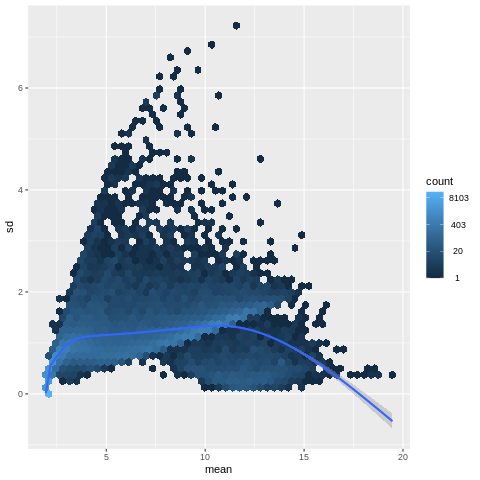

In [ ]:
%%R

## Mean vs. SD plot
px <- rowMeans(assay(vst), na.rm = TRUE)
py <- sqrt(rowSums((assay(vst) - px)^2)/(rowSums(!is.na(assay(vst)))-1))
ggplot(data.frame(px = px, py = py),
       aes(x=px, y=py)) +
  xlab("mean") + ylab("sd") +
  geom_hex(bins = 50) +
  scale_fill_gradient(name = "count", trans = "log", labels = \(x){ format(round(x, 0), nsmall = 0L, scientific = FALSE) }) +
  geom_smooth()

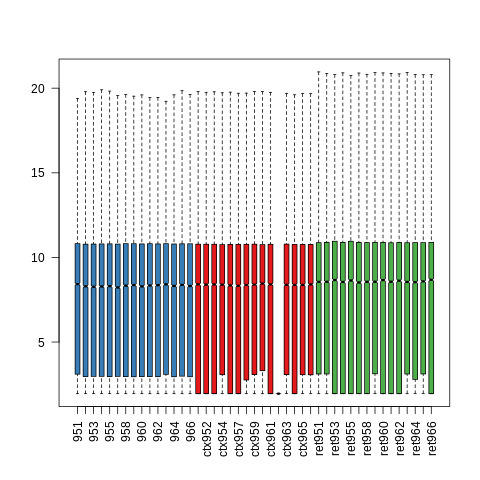

In [ ]:
%%R

## Distribution of expression values
myPalette <- c(brewer.pal(9, "Set1"), brewer.pal(8, "Set2"))
boxplot(assay(vst)[rowData(vst)$gene_type == "protein_coding", ],
        boxwex=0.6, notch=T, outline=FALSE, las=2, col=myPalette[dds$tissue])

In [ ]:
%%R

## One cortex sample is weird: let's remove it!
dds <- dds[, colnames(dds) != "ctx962"]

In [ ]:
%%R

## Filter lowly expressed genes
## We keep only rows that have a count of at least 10 for a minimal number of samples
smallestGroupSize <- 3
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
table(keep)
dds <- dds[keep, ]

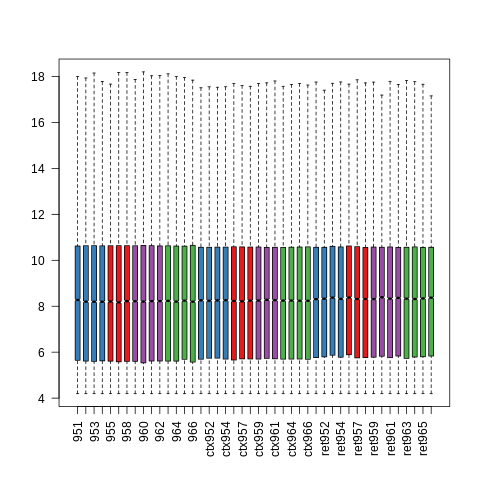

In [ ]:
%%R

## Update vst object
vst <- varianceStabilizingTransformation(dds, blind = TRUE)
boxplot(assay(vst),
        boxwex=0.6, notch=T, outline=FALSE, las=2, col=myPalette[dds$group])

# **Step 3: Quality check**

Here we perform some standard QC procedures.

## Expression of *Xist* gene

Xist is a lncRNA regulating the X-chromosome inactivation process in mammals, used to equalize the dosage of X-linked genes between female (XX) and male (XY). It should thus be expressed only in female samples

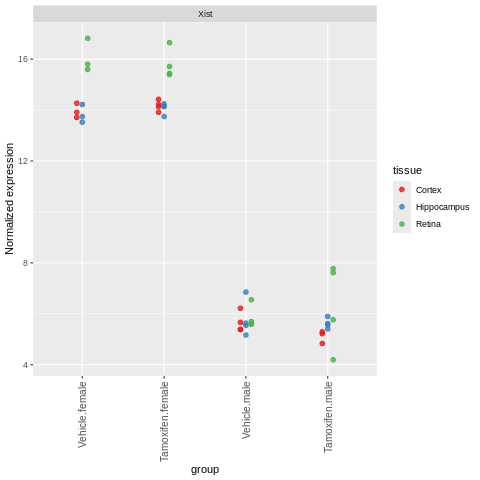

In [ ]:
%%R

df <- assay(vst)[grep("Xist", rowData(dds)$gene_name), , drop=FALSE] |>
  as_tibble(rownames = NA) |>
  rownames_to_column() |>
  dplyr::rename(Gene = rowname) |>
  pivot_longer(cols= colnames(assay(vst)),
               names_to = "Sample",
               values_to = "Normalized expression") |>
  left_join(y=as_tibble(colData(dds)), by = join_by("Sample" == "sra.sample_title")) |>
  left_join(y=as_tibble(rowData(dds)), by=join_by("Gene" == "gene_id"))
ggplot(df, aes(x=group, y=`Normalized expression`, colour=tissue, group=tissue)) +
  facet_wrap( ~ gene_name, scales = "free_y", ncol = 1) +
  geom_point(position = position_dodge(0.2), alpha = .8, size=2) +
  scale_colour_manual(values=myPalette[1:3]) +
  theme(axis.text.x = element_text(size=10, angle = 90, hjust = 1, vjust = 0.5))

## Expression of Y-chromosome genes

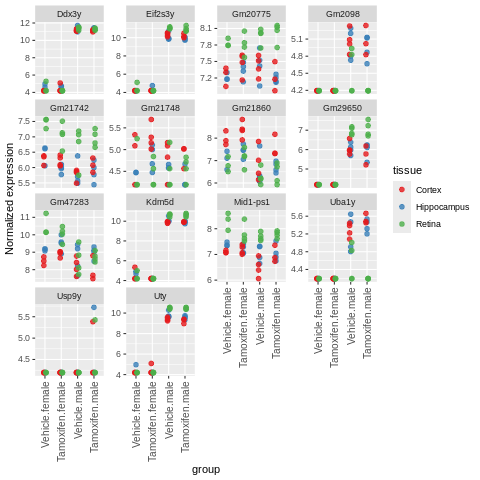

In [ ]:
%%R

## Chromosome information
levels(as.data.frame(rowRanges(dds))$seqnames)
## How many genes are left in our dataset after filtering?
table(as.data.frame(rowRanges(dds))$seqnames == "chrY")

df <- assay(vst)[as.data.frame(rowRanges(dds))$seqnames == "chrY", , drop=FALSE] |>
  as_tibble(rownames = NA) |>
  rownames_to_column() |>
  dplyr::rename(Gene = rowname) |>
  pivot_longer(cols= colnames(assay(vst)),
               names_to = "Sample",
               values_to = "Normalized expression") |>
  left_join(y=as_tibble(colData(dds)), by = join_by("Sample" == "sra.sample_title")) |>
  left_join(y=as_tibble(rowData(dds)), by=join_by("Gene" == "gene_id"))
ggplot(df, aes(x=group, y=`Normalized expression`, colour=tissue, group=tissue)) +
  facet_wrap( ~ gene_name, scales = "free_y", ncol = 4) +
  geom_point(position = position_dodge(0.2), alpha = .8, size=2) +
  scale_colour_manual(values=myPalette[1:3]) +
  theme(axis.text.x = element_text(size=10, angle = 90, hjust = 1, vjust = 0.5))

*    What do you observe? What is going on for some genes? (e.g., *Gm20775*)

*    Bigwig files are available through recount3 for some of the samples and allow to visualize the read coverage (for example on the Y-chromosome) on a genome browser. For example you can provide these links to the UCSC genome browser directly:

In [ ]:
%%R

tail(dds$BigWigURL)

[1] "http://duffel.rail.bio/recount3/mouse/data_sources/sra/base_sums/56/SRP218156/14/sra.base_sums.SRP218156_SRR9956114.ALL.bw"
[2] "http://duffel.rail.bio/recount3/mouse/data_sources/sra/base_sums/56/SRP218156/15/sra.base_sums.SRP218156_SRR9956115.ALL.bw"
[3] "http://duffel.rail.bio/recount3/mouse/data_sources/sra/base_sums/56/SRP218156/16/sra.base_sums.SRP218156_SRR9956116.ALL.bw"
[4] "http://duffel.rail.bio/recount3/mouse/data_sources/sra/base_sums/56/SRP218156/17/sra.base_sums.SRP218156_SRR9956117.ALL.bw"
[5] "http://duffel.rail.bio/recount3/mouse/data_sources/sra/base_sums/56/SRP218156/18/sra.base_sums.SRP218156_SRR9956118.ALL.bw"
[6] "http://duffel.rail.bio/recount3/mouse/data_sources/sra/base_sums/56/SRP218156/19/sra.base_sums.SRP218156_SRR9956119.ALL.bw"


# **Step 4: Principal Component Analysis**

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


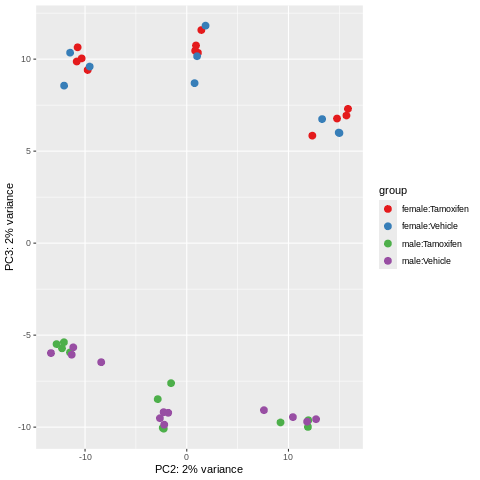

In [ ]:
%%R

# PCA on top 500 most variable genes
plotPCA(vst,
        ntop = 500,
        intgroup=c("tissue", "treatment"),
        pcsToUse = 1:2) +
  scale_colour_manual(values=myPalette[1:6]) +
  coord_cartesian()

## Plot deeper components
plotPCA(vst,
        ntop = 500,
        intgroup=c("sex", "treatment"),
        pcsToUse = 2:3) +
  scale_colour_manual(values=myPalette[1:6]) +
  coord_cartesian()

*    To which principal components contribute which factors? Does this corresponds to the expectations? What do you conclude on the relative effect size of different factors?

# **Step 5: Differential Expression Analysis**

In [ ]:
%%R

## Update design for DE analysis
design(dds) <- ~ 0 + group + tissue

## Launch differential expression analysis
dds <- DESeq(dds)
resultsNames(dds)

[1] "groupVehicle.female"   "groupTamoxifen.female" "groupVehicle.male"    
[4] "groupTamoxifen.male"   "tissueHippocampus"     "tissueRetina"         


## Extract results for the different contrasts

## Direct male vs. female comparison (in controls only)

In [ ]:
%%R

res <- results(dds, contrast=c("group", "Vehicle.male", "Vehicle.female"))
summary(res)
res <- cbind(res, rowData(dds)$gene_name)
head(res[order(res$pvalue),], n=10)


out of 25314 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 19, 0.075%
LFC < 0 (down)     : 46, 0.18%
outliers [1]       : 45, 0.18%
low counts [2]     : 5392, 21%
(mean count < 20)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

DataFrame with 10 rows and 7 columns
                     baseMean log2FoldChange     lfcSE      stat       pvalue
                    <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSMUSG00000069045  1296.4534      10.289768 0.3405561   30.2146 1.52292e-200
ENSMUSG00000056673   610.3640       8.736114 0.3096079   28.2167 3.64787e-175
ENSMUSG00000086503 15993.1573      -9.743607 0.4468543  -21.8049 2.08535e-105
ENSMUSG00000085715   986.8578      -8.190900 0.4309121  -19.0083  1.45637e-80
ENSMUSG00000069049   748.8289      11.095832 0.5970270   18.5851  4.23872e-77
ENSMUSG00000068457   497.0480      10.134968 0.5745282   17.6405  1.20378e-69
ENSMUSG00000035150  3743.6424    

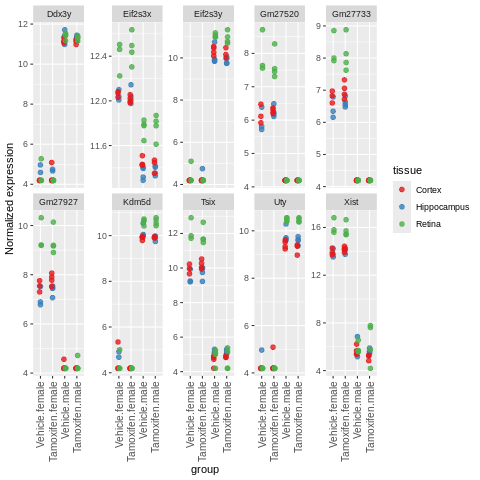

In [ ]:
%%R

df <- assay(vst)[row.names(head(res[order(res$pvalue),], n=10)), ] |>
  as_tibble(rownames = NA) |>
  rownames_to_column() |>
  dplyr::rename(Gene = rowname) |>
  pivot_longer(cols= colnames(assay(vst)),
               names_to = "Sample",
               values_to = "Normalized expression") |>
  left_join(y=as_tibble(colData(dds)), by = join_by("Sample" == "sra.sample_title")) |>
  left_join(y=as_tibble(rowData(dds)), by=join_by("Gene" == "gene_id"))
ggplot(df, aes(x=group, y=`Normalized expression`, group=tissue, col=tissue)) +
  facet_wrap( ~ gene_name, scales = "free_y", ncol = 5) +
  geom_point(position = position_dodge(0.2), alpha = .8, size=2) +
  scale_colour_manual(values=myPalette[1:3]) +
  theme(axis.text.x = element_text(size=10, angle = 90, hjust = 1, vjust = 0.5))

## Effect of Tamoxifen treatment in males

In [ ]:
%%R

res <- results(dds, contrast=c("group", "Tamoxifen.male", "Vehicle.male"))
summary(res)
res <- cbind(res, rowData(dds)$gene_name)
head(res[order(res$pvalue),], n=10)


out of 25314 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 18, 0.071%
LFC < 0 (down)     : 32, 0.13%
outliers [1]       : 45, 0.18%
low counts [2]     : 7839, 31%
(mean count < 53)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

DataFrame with 10 rows and 7 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000066687 1775.0417      -0.979866 0.1059546  -9.24798 2.28771e-20
ENSMUSG00000022602 8859.8087       0.580085 0.0765352   7.57932 3.47379e-14
ENSMUSG00000021250 1608.6033       0.524210 0.0791697   6.62135 3.55943e-11
ENSMUSG00000025316 1183.0364      -0.371149 0.0604447  -6.14031 8.23621e-10
ENSMUSG00000025324  412.8755      -0.503888 0.0911208  -5.52989 3.20438e-08
ENSMUSG00000032193 1258.5556       0.405530 0.0736310   5.50761 3.63748e-08
ENSMUSG00000025952   34.6641      17.659165 3.230

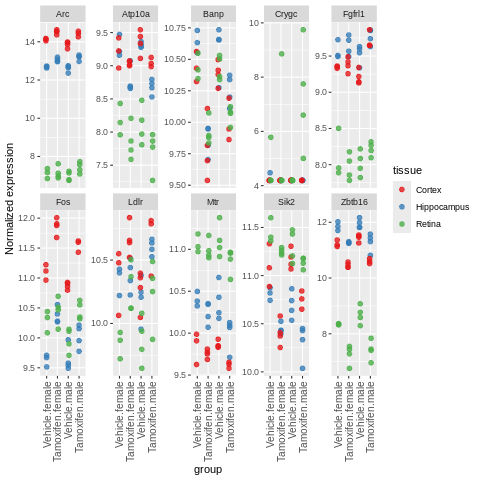

In [ ]:
%%R

df <- assay(vst)[row.names(head(res[order(res$pvalue),], n=10)), ] |>
  as_tibble(rownames = NA) |>
  rownames_to_column() |>
  dplyr::rename(Gene = rowname) |>
  pivot_longer(cols= colnames(assay(vst)),
               names_to = "Sample",
               values_to = "Normalized expression") |>
  left_join(y=as_tibble(colData(dds)), by = join_by("Sample" == "sra.sample_title")) |>
  left_join(y=as_tibble(rowData(dds)), by=join_by("Gene" == "gene_id"))
ggplot(df, aes(x=group, y=`Normalized expression`, group=tissue, col=tissue)) +
  facet_wrap( ~ gene_name, scales = "free_y", ncol = 5) +
  geom_point(position = position_dodge(0.2), alpha = .8, size=2) +
  scale_colour_manual(values=myPalette[1:3]) +
  theme(axis.text.x = element_text(size=10, angle = 90, hjust = 1, vjust = 0.5))

## Effect of Tamoxifen treatment in females

In [ ]:
%%R

res <- results(dds, contrast=c("group", "Tamoxifen.female", "Vehicle.female"))
summary(res)
res <- cbind(res, rowData(dds)$gene_name)
head(res[order(res$pvalue),], n=10)


out of 25314 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 59, 0.23%
LFC < 0 (down)     : 227, 0.9%
outliers [1]       : 45, 0.18%
low counts [2]     : 9310, 37%
(mean count < 94)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

DataFrame with 10 rows and 7 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000025316  1183.036      -0.666516 0.0640143 -10.41199 2.18611e-25
ENSMUSG00000004328   262.763      -1.162027 0.1210255  -9.60151 7.87826e-22
ENSMUSG00000066687  1775.042      -0.841603 0.1119219  -7.51956 5.49616e-14
ENSMUSG00000020484  3255.452      -0.332475 0.0466068  -7.13362 9.77653e-13
ENSMUSG00000021250  1608.603       0.579880 0.0833544   6.95680 3.48095e-12
ENSMUSG00000026773  2180.037      -0.412198 0.0611925  -6.73609 1.62703e-11
ENSMUSG00000024222  2141.045      -0.438681 0.0671

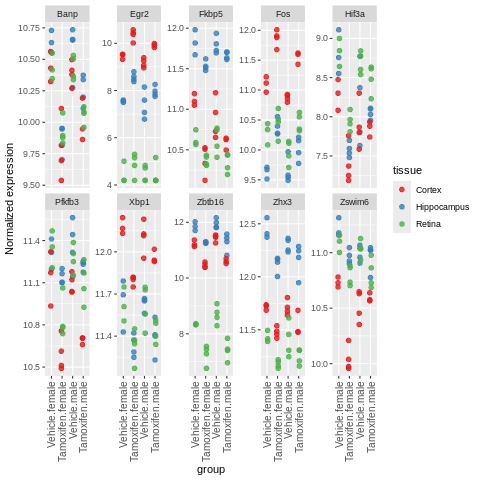

In [ ]:
%%R

df <- assay(vst)[row.names(head(res[order(res$pvalue),], n=10)), ] |>
  as_tibble(rownames = NA) |>
  rownames_to_column() |>
  dplyr::rename(Gene = rowname) |>
  pivot_longer(cols= colnames(assay(vst)),
               names_to = "Sample",
               values_to = "Normalized expression") |>
  left_join(y=as_tibble(colData(dds)), by = join_by("Sample" == "sra.sample_title")) |>
  left_join(y=as_tibble(rowData(dds)), by=join_by("Gene" == "gene_id"))
ggplot(df, aes(x=group, y=`Normalized expression`, group=tissue, col=tissue)) +
  facet_wrap( ~ gene_name, scales = "free_y", ncol = 5) +
  geom_point(position = position_dodge(0.2), alpha = .8, size=2) +
  scale_colour_manual(values=myPalette[1:3]) +
  theme(axis.text.x = element_text(size=10, angle = 90, hjust = 1, vjust = 0.5))

*    Do the number of DE genes correspond to your expectations from the PCA? What would you conclude on the difference of Tamoxifen effects in male and female? Are some of these genes described in the original paper?

In [ ]:
%%R

## See Fig 4e and f
data.frame(res[rowData(dds)$gene_name %in% c("Egr2", "Fos", "Dusp1", "Nr4a1", "Sik1", "Arc", "Egr1", "Plcl2", "Galnt9", "Per2", "Zbtb16", "Map3k13", "Banp"), ])

                    baseMean log2FoldChange      lfcSE       stat       pvalue
ENSMUSG00000055866 1502.2350     -0.4609004 0.08358010  -5.514476 3.498206e-08
ENSMUSG00000037868  349.9354      1.0836466 0.16775092   6.459855 1.048033e-10
ENSMUSG00000021250 1608.6033      0.5798797 0.08335440   6.956797 3.480950e-12
ENSMUSG00000022602 8859.8087      0.3186190 0.08046486   3.959729 7.503498e-05
ENSMUSG00000023034 3315.9279      0.4635517 0.08029831   5.772870 7.793254e-09
ENSMUSG00000033618 2228.9591     -0.3017350 0.05564475  -5.422524 5.876325e-08
ENSMUSG00000024190 1209.9096      0.3230613 0.08355055   3.866657 1.103377e-04
ENSMUSG00000024042  671.6219      0.2326045 0.10027011   2.319779 2.035285e-02
ENSMUSG00000038910 2458.3888     -0.1593573 0.06097903  -2.613313 8.966902e-03
ENSMUSG00000038418 9691.4256      0.4367312 0.11062756   3.947761 7.888547e-05
ENSMUSG00000033316 3574.2651     -0.1516976 0.07406778  -2.048091 4.055109e-02
ENSMUSG00000025316 1183.0364     -0.6665160 0.064014

## Extracting the interaction term

We would like to identify genes reacting differently to Tamoxifen treatment in male and female. We need to update the design of our DESe2 object. See `?DESeq2::results` explaining how to extract this effect (Example 3)

In [ ]:
%%R

design(dds) <- ~ tissue + treatment * sex
dds <- DESeq(dds)
resultsNames(dds)

## Select last coefficient
res <- results(dds, name="treatmentTamoxifen.sexmale")
summary(res)
res <- cbind(res, rowData(dds)$gene_name)
head(res[order(res$pvalue),], n=10)


out of 25314 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3, 0.012%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 45, 0.18%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

DataFrame with 10 rows and 7 columns
                     baseMean log2FoldChange     lfcSE      stat      pvalue
                    <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000004328   262.7627       0.996614 0.1662446   5.99487 2.03654e-09
ENSMUSG00000056673   610.3640       3.800710 0.6739355   5.63958 1.70470e-08
ENSMUSG00000025952    34.6641      25.644635 4.6820234   5.47725 4.31975e-08
ENSMUSG00000030168  3687.4690       0.223268 0.0542939   4.11220 3.91904e-05
ENSMUSG00000091462    34.0167      -1.339289 0.3349684  -3.99825 6.38116e-05
ENSMUSG00000052040  6658.2761       0.291482 0.0729475   3.99578 6.44803e-05
ENSMUSG00000037754  4999.1823       0.277067 0.0695

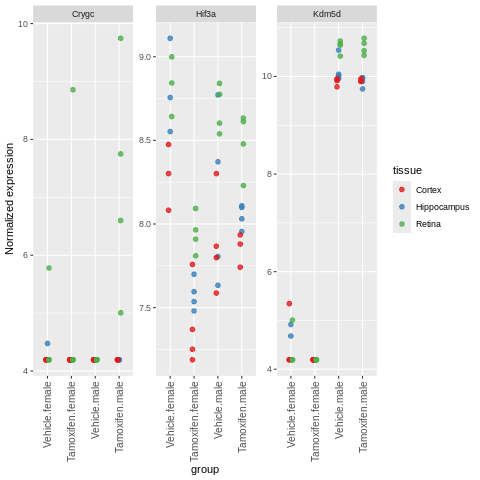

In [ ]:
%%R

df <- assay(vst)[row.names(head(res[order(res$pvalue),], n=3)), ] |>
  as_tibble(rownames = NA) |>
  rownames_to_column() |>
  dplyr::rename(Gene = rowname) |>
  pivot_longer(cols= colnames(assay(vst)),
               names_to = "Sample",
               values_to = "Normalized expression") |>
  left_join(y=as_tibble(colData(dds)), by = join_by("Sample" == "sra.sample_title")) |>
  left_join(y=as_tibble(rowData(dds)), by=join_by("Gene" == "gene_id"))
ggplot(df, aes(x=group, y=`Normalized expression`, group=tissue, col=tissue)) +
  facet_wrap( ~ gene_name, scales = "free_y", ncol = 5) +
  geom_point(position = position_dodge(0.2), alpha = .8, size=2) +
  scale_colour_manual(values=myPalette[1:3]) +
  theme(axis.text.x = element_text(size=10, angle = 90, hjust = 1, vjust = 0.5))

*    What do you think about these results? Are these genes described in the original paper? How would you describe the behavior of these genes in (well chosen) simple words?

#  **Step 6: Final reflections**


-   "*Interpretations of sex-related variation are not always commensurate with the story the data actually tell*" (Pape et al. 2024). How do you judge the interpretations of the results in the published paper?

-   Discuss potential limitations of the paper and the conclusion about the absence of Tamoxifen effect.

    -   What is important to notice in the design of the experiment (tamoxifen treatment duration, batches, number of replicates, ...)?
    -   Have a look at the results and materials and methods section: which analyses were made and how could they influence the results?

-   Limitations of our reanalysis: what could be improved if we had more time?

    -   Try subsetting the dataset to one tissue as done by the authors. What do you notice?

    -   It is possible that we detect few significant genes for the interaction but that some trends are visible collectively at the gene set level. See the more davanced scripts on the Github repository allowing you to explore this

-   "*Sex is not a causal mechanism*" (Pape et al. 2024): follow-up on some DE genes and try to find which mechanism of action could explain their differential expression patterns.

-   Discuss what would be the next steps if that was your research project. Which experiments would you design next? How would you describe the results in a paper?

    -   You can also have a look at other related papers (e.g., https://www.nature.com/articles/s41586-022-04686-1, https://www.ahajournals.org/doi/10.1161/ATVBAHA.123.319922)
    -   Or look at follow-up papers from the same authors (e.g., https://link.springer.com/article/10.1007/s12035-022-02860-0)